In [ ]:
# Goal:
# Building, Training and testing Neural Network from scracth like Pytorch
# Building pytorch like library
# I will call this project as opengrad
# Will be keep improving this project and keep adding new features in the future
# This notebook is just for learning for opengrad will create a new repo


# Motivation / Source
# Ref of this Learning is from micrograd and Tinygrad

# Theory
# Automatic Gradient df/dx
# Auto grad is what you need to train neural networks and everything else is efficiency
# Bacpropagation auto grad engine - Gives power to neural networks
# nn library
# Neuron, Layer, perceptron
# Differentiation is just rate of change
# My understanding - changing something to see output changes/behaves on that change - kind of like a attention
# I can see the attention mechanism from here only change if you get right attention then keep changing in that direction
# Will see that in future that my understanding is correct or not

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

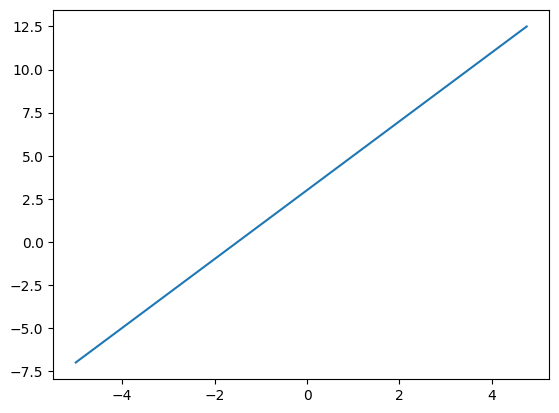

In [ ]:
# Differentiaion of the equation
# (f(a + h) - f(a)) / h ; h -> 0

def f1(x):
    return 2 * x + 3
x1_s = np.arange(-5, 5, 0.25)
y1_s = f1(x1_s)
plt.plot(x1_s, y1_s)


In [11]:
def f(x):
    return 2 * x**2 - 3 * x + 2
f(4.0)

22.0

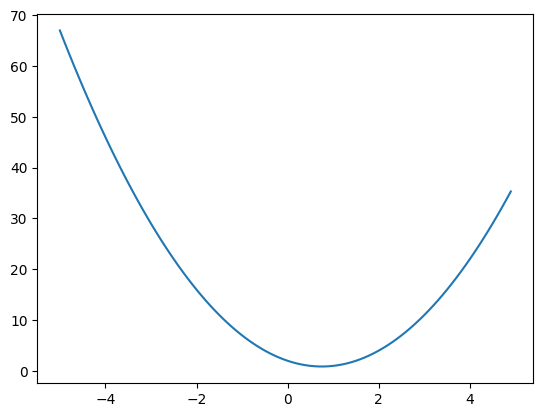

In [15]:
xs = np.arange(-5, 5, 0.1)
xs
ys = f(xs)
ys
plt.plot(xs, ys)

In [ ]:
x = 4.0
h = 0.00001
print(f(x))
(f(x + h) - f(x)) / h 

22.0


13.000019999154231

In [23]:
# Equation with multiple variable
h = 0.00001
a = 2
b = -3
c = 10
d1 = a * b + c

a += h
d2 = a * b + c
print(f"d1: {d1}")
print(f"d2: {d2}")
print(f"Slope: {(d2 - d1) / h}")

d1: 4
d2: 3.9999699999999994
Slope: -3.000000000064062


In [35]:
class Value:
    def __init__(self, data, _children=(), op=''):
        self.data = data
        self._prev = set(_children)
        self._op = op
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out        

In [36]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10)
d = a * b + c


In [37]:
d._prev

{Value(data=-6.0), Value(data=10)}

In [38]:
d._op

'+'

In [ ]:
# Build grahp visualizer
from graphviz import Digraph

def visualize(node):
    # Build a expression graph
    # then do plotting
    
